In [9]:
from FOV import LIF_info
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from skimage import exposure, util
from skimage import data, img_as_float
from skimage.color import gray2rgb


In [10]:
# Set directory of image stack
file_pattern = '/fs/pool/pool-pub/EMBO/FLM/PreImaged_Yeast/20240416_Yeast_CA_GE_18/20240416_Yeast_CA_GE_18_tiles.lif'
#'/fs/pool/pool-pub/EMBO/FLM/PreImaged_Yeast/20240402_Yeast_CA_GE_05/CA_GE_05_tiles.lif'
stack_naming_pattern = ['Pos','FOV'] #add your naming as you like
f = LIF_info(lif_path=file_pattern,FOV_num=1,FOV_naming=stack_naming_pattern)


# Set directory of image stack
file_pattern = '/fs/pool/pool-pub/EMBO/FLM/PreImaged_Yeast/20240416_Yeast_CA_GE_18/20240416_Yeast_CA_GE_18_OV.lif'
ov = LIF_info(lif_path=file_pattern, overview=True)


In [11]:
ov.get_image(0,0).dims.x

2048

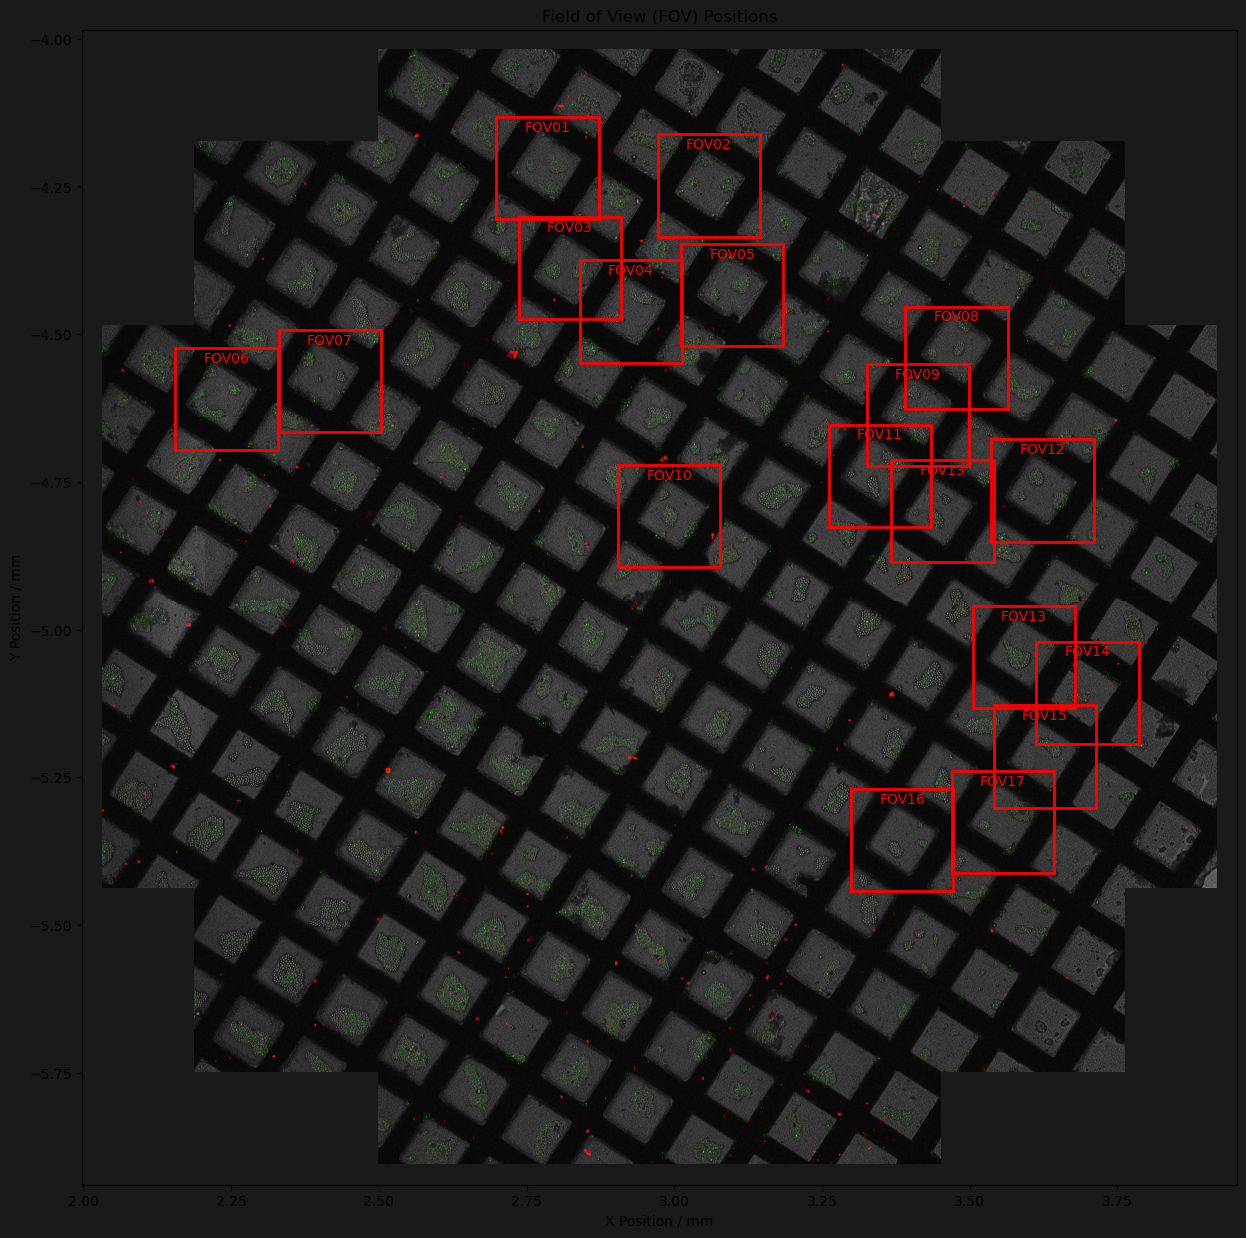

In [13]:
def overlay_channels(lif_image, mosaic_num):
    img_size = (lif_image.dims.x, lif_image.dims.y)
    channels = [np.array(i)/255 for i in lif_image.get_iter_c(m=mosaic_num)]

    red_image = np.zeros((*img_size, 3))
    red_image[:, :, 0] = channels[0]  # Assign the red channel 

    green_image = np.zeros((*img_size, 3))
    green_image[:, :, 1] = channels[1] # Assign the red channel
           
    grey_image = gray2rgb(channels[2])
    tile = img_as_float(red_image + green_image + grey_image)
    tile = np.clip(tile, 0, 1)
    return tile

#fig, ax = f.plot_FOVs()
fig,ax = plt.subplots(figsize=(15,15))


df = ov.get_mosaic_tiles(ov.tilescans[0][1])
df['@PosX'], df['@PosY'] = df['@PosX']*1e3, -df['@PosY']*1e3

# FIXME get the resolution in class for overview as well
scale = f.resolution[f.resolution['dimension_name'] == 'x']['length'][0] *1e3 # Example scale factor for the size of the rectangles

lif_image = ov.get_image(0,0)

# Add rectangles for each FOV
for index, row in df.iterrows():
    #rect = patches.Rectangle((row['@PosX'], row['@PosY']), scale, scale, linewidth=1, edgecolor='g', facecolor='none')
    #ax.add_patch(rect)
    ax.imshow(overlay_channels(lif_image,index),extent=[row['@PosX'] , row['@PosX'] + scale, row['@PosY'],  row['@PosY'] + scale ], cmap='Greys')
    # Optionally add text labels
    #ax.text(row['@PosX'] + scale / 2, row['@PosY'] - scale*0.1, int(row['@FieldX']), ha='center', va='center',size=8)


df2 = f.get_FOV_dict_coords()
df2['X'] = df2['X']*1e3
df2['Y'] = -df2['Y']*1e3

scale = f.resolution[f.resolution['dimension_name'] == 'x']['length'][0] *1e3 # Example scale factor for the size of the rectangles

# Add rectangles for each FOV
for index, row in df2.iterrows():
    rect = patches.Rectangle((row['X'], row['Y']), scale, scale, linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    # Optionally add text labels
    ax.text(row['X'] + scale / 2, row['Y'] + scale*0.9, row['FOV_name'], ha='center', va='center',size=10, color='red')


ax.set_xlim(df['@PosX'].min() - scale*0.2, df['@PosX'].max() + 1.2*scale)
ax.set_ylim(df['@PosY'].min() - scale*0.2, df['@PosY'].max() + 1.2*scale)
ax.set_xlabel('X Position / mm')
ax.set_ylabel('Y Position / mm')
ax.set_facecolor((0.1, 0.1, 0.1))
fig.set_facecolor((0.1, 0.1, 0.1))
ax.set_title('Field of View (FOV) Positions')

fig.savefig('FOV_overlay.png',dpi=300)